In [26]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import shap
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer, RocCurveDisplay
from itertools import combinations

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

import warnings

76ce1cac32fd668df71e4f428d1bd42710e3cbda5fe1712f

In [2]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\Script\\Microarray_Script\\DatasetReduced'

In [2]:
os.chdir("../../../SYMBOL/Results/DatasetReduced")
# os.chdir("../store/DatasetReduced")

<h2>Dataset Upload</h2>

In [3]:
dataset = pd.read_csv('../../Dataset/MergedDatasetReducedCombatDeclustered_symbol.csv')
label = dataset['Label']
dataset.drop(columns=['SampleID', 'PatientID', 'Label'], inplace=True)
dataset

XPO6    ARPC1A     THOP1    ATP2B2      CSTA       PKM  MAPK1IP1L  \
0    10.525171  7.022214  6.483224  5.848133  7.591375  8.987009   9.548412   
1    10.881165  6.973561  6.813249  5.887911  7.668762  9.267965   9.533519   
2    11.430331  7.140780  6.688973  5.984697  7.571597  9.025906   9.516713   
3    11.385201  7.144255  6.482745  5.616827  7.819636  9.037302   9.581727   
4    11.344344  7.067116  6.384345  5.762024  7.962971  9.252510   9.611660   
..         ...       ...       ...       ...       ...       ...        ...   
724  10.931859  7.106400  6.789337  6.003297  7.964093  9.272532   9.508226   
725  10.765313  7.079116  6.572470  5.744757  7.963980  9.123222   9.528200   
726  10.977433  7.030231  6.554086  5.716029  7.972142  9.102181   9.592449   
727  10.589295  7.081161  6.484474  5.744757  7.956867  9.140242   9.534618   
728  11.134102  7.035903  6.556645  5.601516  7.959362  9.151900   9.597398   

        ABCG2     LAMB1    ZBTB25  ...    ACTL6A    MS4A6A     BAZ2A  \
0    5.041454  4.727907  7.953158  ...  6.906047  9.119511  7.989939   
1    4.883477  4.744346  7.765002  ...  6.886462  9.133109  8.325695   
2    4.793884  4.820963  7.793955  ...  6.885936  9.222653  8.301554   
3    5.051594  4.575038  7.860573  ...  6.919007  9.323385  8.333977   
4    4.949163  4.675678  7.592638  ...  6.921658  9.388868  8.496262   
..        ...       ...       ...  ...       ...       ...       ...   
724  4.904147  4.696315  7.671851  ...  6.862112  9.286014  8.442553   
725  4.770082  4.707677  7.755028  ...  6.990629  9.269902  8.108137   
726  4.973374  4.696023  7.771111  ...  6.971580  9.253054  8.279138   
727  5.150804  4.674931  7.817850  ...  6.969681  9.256837  8.083611   
728  5.216203  4.705052  7.863808  ...  6.973779  9.266940  8.331888   

         TPM1    DIABLO     DOC2A     DEFA4    COX7A2    RPS4Y1     IFI44  
0    7.300196  7.917960  5.448753  6.064862  8.905161  6.083871  7.861560  
1    7.226071  7.920274  5.776065  6.204405  9.027083  5.938436  7.793113  
2    7.299852  7.866331  5.740622  6.051944  8.936827  5.924100  8.199732  
3    7.363228  7.953213  5.165763  6.114210  9.250595  5.951088  7.803589  
4    7.254713  7.891466  5.287396  5.935075  9.036619  6.151681  8.945151  
..        ...       ...       ...       ...       ...       ...       ...  
724  7.370798  7.970275  5.338771  6.390358  9.111883  6.359453  7.864455  
725  7.307330  7.984256  5.452894  5.961750  9.158106  6.377977  7.876844  
726  7.338065  7.993246  5.532808  5.878172  9.134744  6.361933  7.872425  
727  7.385615  7.974383  5.427824  6.514266  9.168598  6.343867  7.930993  
728  7.382921  7.974383  5.456992  6.426990  9.118374  6.418308  7.887741  

[729 rows x 11482 columns]

In [4]:
gradientBoosting = joblib.load("xgbDefReduced.pkl")

current = dataset.copy()
current_Scaled = gradientBoosting[0].transform(current)
current_Scaled = pd.DataFrame(current_Scaled, columns=current.columns)
current_Scaled.insert(0, 'Label', label)

n = int(current_Scaled.shape[0] * 0.1)

print(n)

noMS = current_Scaled[current_Scaled['Label'] == 0].sample(n, random_state=42)
ms = current_Scaled[current_Scaled['Label'] == 1].sample(n, random_state=42)

currentBack = pd.concat([noMS, ms]).sample(frac=1, random_state=42).reset_index(drop=True)

currentBack.drop(columns=['Label'], inplace=True)
current_Scaled.drop(columns=['Label'], inplace=True)

72


<h2> SHAP Explanations</h3>

In [6]:
explainer = shap.TreeExplainer(gradientBoosting[-1], currentBack)
shap_object = explainer(current_Scaled)

shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(gradientBoosting.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))
expl_sorted

{'HLA-DRB1': 0.7065481773974343,
 'HFE': 0.259880542426628,
 'H2AZ1': 0.25783058447959395,
 'DNAJA3': 0.22564182367047395,
 'EIF4G1': 0.19942400699243742,
 'RPL11': 0.1955835532569116,
 'TRIB1': 0.17302833752783325,
 'KCTD2': 0.16890913605078742,
 'CYP27A1': 0.16525661073860168,
 'RAPGEF1': 0.15866205442931935,
 'SNAP29': 0.147761292749574,
 'SPATA7': 0.14448522095887226,
 'ADAT1': 0.1382112167635357,
 'TAGLN': 0.1316889349607668,
 'CROCC': 0.13125392003287675,
 'H2BC21': 0.12969591536901517,
 'TIMM10': 0.12744590909082942,
 'THG1L': 0.1251619574401224,
 'PFKP': 0.12511524049008205,
 'NEDD8': 0.11789760027495966,
 'ZNF473': 0.11767678991197736,
 'SYF2': 0.116113769866779,
 'CDKN1C': 0.11430518095653672,
 'CSK': 0.11401176115306366,
 'ADAM15': 0.11338674242101096,
 'RBM6': 0.11292999962464861,
 'EIF2AK2': 0.11239747136732282,
 'SFSWAP': 0.11032205428401834,
 'EXOSC1': 0.11009614327474057,
 'ABL1': 0.10586606525158111,
 'MYOM1': 0.10328080834751249,
 'ABCA1': 0.10258342867489734,
 'KLF3-

In [57]:
def addClusterGenes(geneList):
    clusters = joblib.load("uniqueClustersReduced.pkl")
    for key, value in clusters.items():
        print(value, value in geneList)
        
        if value in geneList:
            insertElements = [gene for gene in key if gene != value]
            idx = geneList.index(value)
            geneList[idx+1:idx+1] = insertElements
    return geneList

shap_object = joblib.load("xgbDefReduced_shapValues.pkl")
expl_sorted = joblib.load("xgbDefReduced_explSorted.pkl")
feature_nonZero = [k for k, v in expl_sorted.items() if v != 0]

<h2>Explorative Graphs</h2>

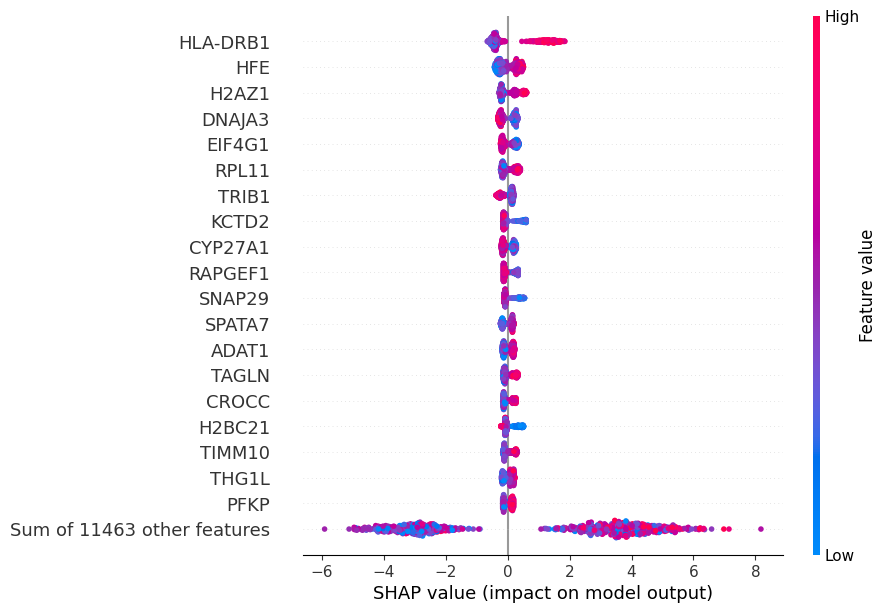

In [6]:
plt.close()
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_object, max_display=20, plot_size=(10, 7), show=False)
fig.subplots_adjust(left=0.3)

Text(0.5, 1.0, 'Top 25 features for importance')

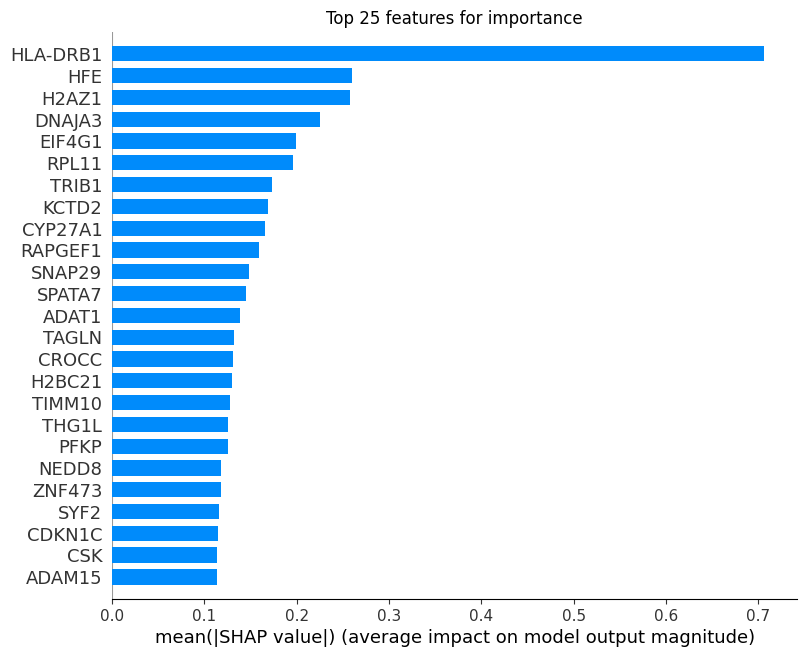

In [7]:
plt.close()
fig, ax = plt.subplots()
shap.summary_plot(shap_object, max_display=25, plot_type="bar", show=False, plot_size=(10, 7))
fig.subplots_adjust(left=0.3, top=0.9)
plt.title('Top 25 features for importance')

In [8]:
cont = 0
for value in expl_sorted.values():
      if value != 0:
        cont+=1

print('Feature con importanza non zero:', cont)

Feature con importanza non zero: 617


<h3>Bar plot of importances over the two classes</h3>

In [44]:
current = current_Scaled.copy()
current.insert(0, 'Label', label)


cohorts = ["MS" if label == 1 else "Control" for label in current['Label']]
cohort_explanation = shap_object.cohorts(cohorts)
cohort_means = cohort_explanation.abs.mean(0)

cohort_df = pd.DataFrame({
    'MS': cohort_explanation.cohorts['MS'].values.mean(0),  # Media per MS
    'Control': cohort_explanation.cohorts['Control'].values.mean(0)  # Media per Control
}, index=current_Scaled.columns)  # Usa le feature come indice

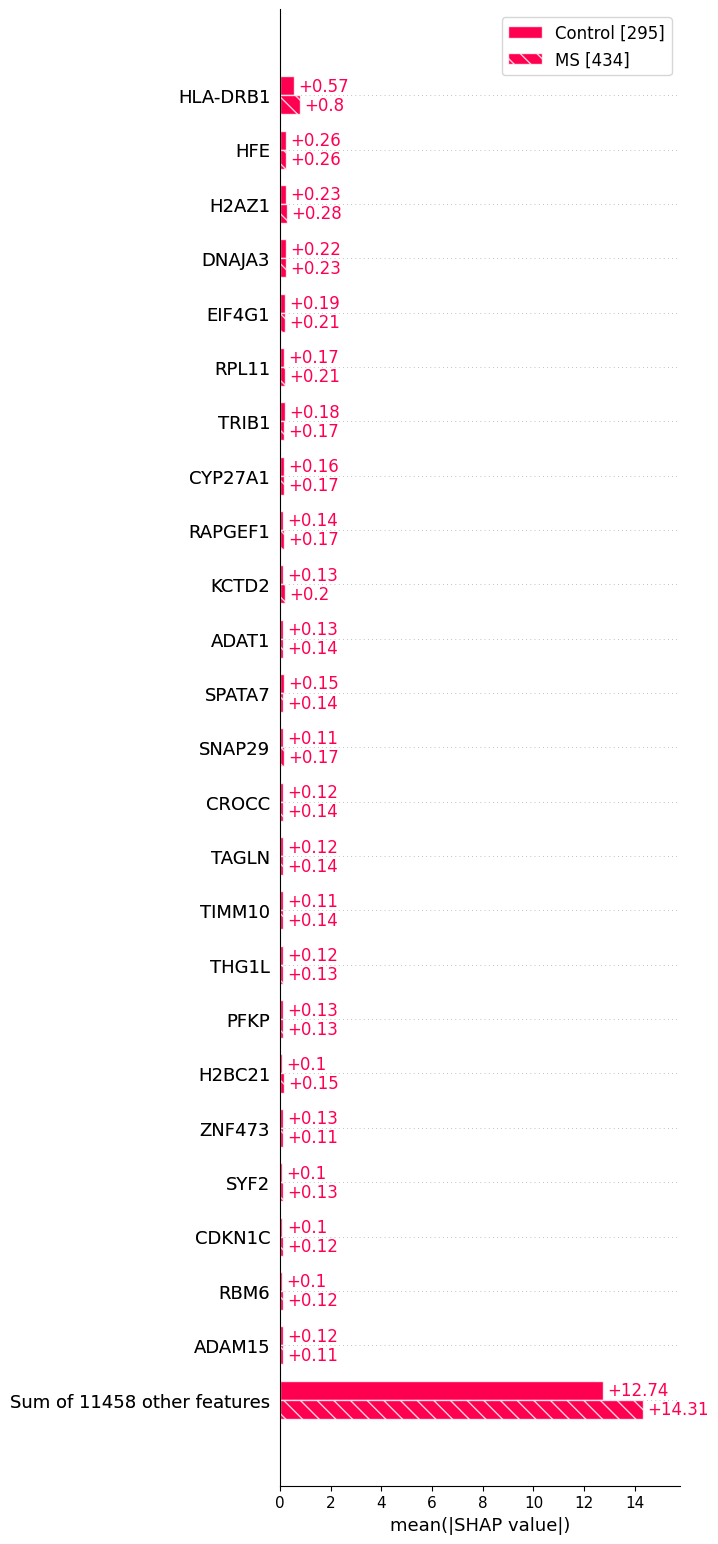

In [45]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 5))
shap.plots.bar(cohort_means, max_display=25, show=False)
fig.subplots_adjust(left=0.4)

Showing the genes where the importance for the class MS is higher than a value epsilon compared to the importance of the Control class

In [46]:
diff = np.abs(cohort_df['MS'] - cohort_df['Control'])

Difference importance between classes distribution

In [68]:
diff_mean = np.mean(diff)
diff_meadian = np.median(diff)
diff_std = np.std(diff)

print('Mean:', diff_mean)
print('Median:', diff_meadian)
print('Stadnard Deviation:', diff_std)
k=0
bestFeatures = [key for key, value in expl_sorted.items() if value > (k*diff_std)+diff_mean]
print(f"Number of features over {k} sigma:", len(bestFeatures), bestFeatures)

Mean: 0.0007994314876070078
Median: 0.0
Stadnard Deviation: 0.007607923290616991
Number of features over 0 sigma: 617 ['HLA-DRB1', 'HFE', 'H2AZ1', 'DNAJA3', 'EIF4G1', 'RPL11', 'TRIB1', 'KCTD2', 'CYP27A1', 'RAPGEF1', 'SNAP29', 'SPATA7', 'ADAT1', 'TAGLN', 'CROCC', 'H2BC21', 'TIMM10', 'THG1L', 'PFKP', 'NEDD8', 'ZNF473', 'SYF2', 'CDKN1C', 'CSK', 'ADAM15', 'RBM6', 'EIF2AK2', 'SFSWAP', 'EXOSC1', 'ABL1', 'MYOM1', 'ABCA1', 'KLF3-AS1', 'SERTAD2', 'MOGS', 'TMSB10', 'ADRB2', 'STARD3', 'MAB21L1', 'CXCR4', 'RFTN1', 'IFNA4', 'RPAIN', 'GORASP1', 'CBLL1', 'TPST1', 'PCTP', 'DEPP1', 'ZNF711', 'MAMLD1', 'BZW1', 'IL27RA', 'CHST2', 'TM9SF1', 'CABP5', 'ING2', 'IER5', 'UBE2B', 'ZNF354A', 'IPPK', 'AQR', 'COX7A2', 'PF4V1', 'H2AC17', 'NOL11', 'CDC27', 'MRFAP1L1', 'KLF4', 'SLC2A1', 'PLA2G7', 'CENPB', 'BID', 'SCMH1', 'PLLP', 'NUAK2', 'CCNE2', 'FZD1', 'HMGN1', 'GNAQ', 'KIR2DS5', 'RSRC2', 'ZFYVE9', 'DEDD', 'CAPN1', 'IFNA6', 'PEX6', 'PHF1', 'FEZ1', 'AVPR1A', 'EGR3', 'CPA3', 'ACO2', 'PRKCD', 'LGALS1', 'RMC1', 'TENM1'

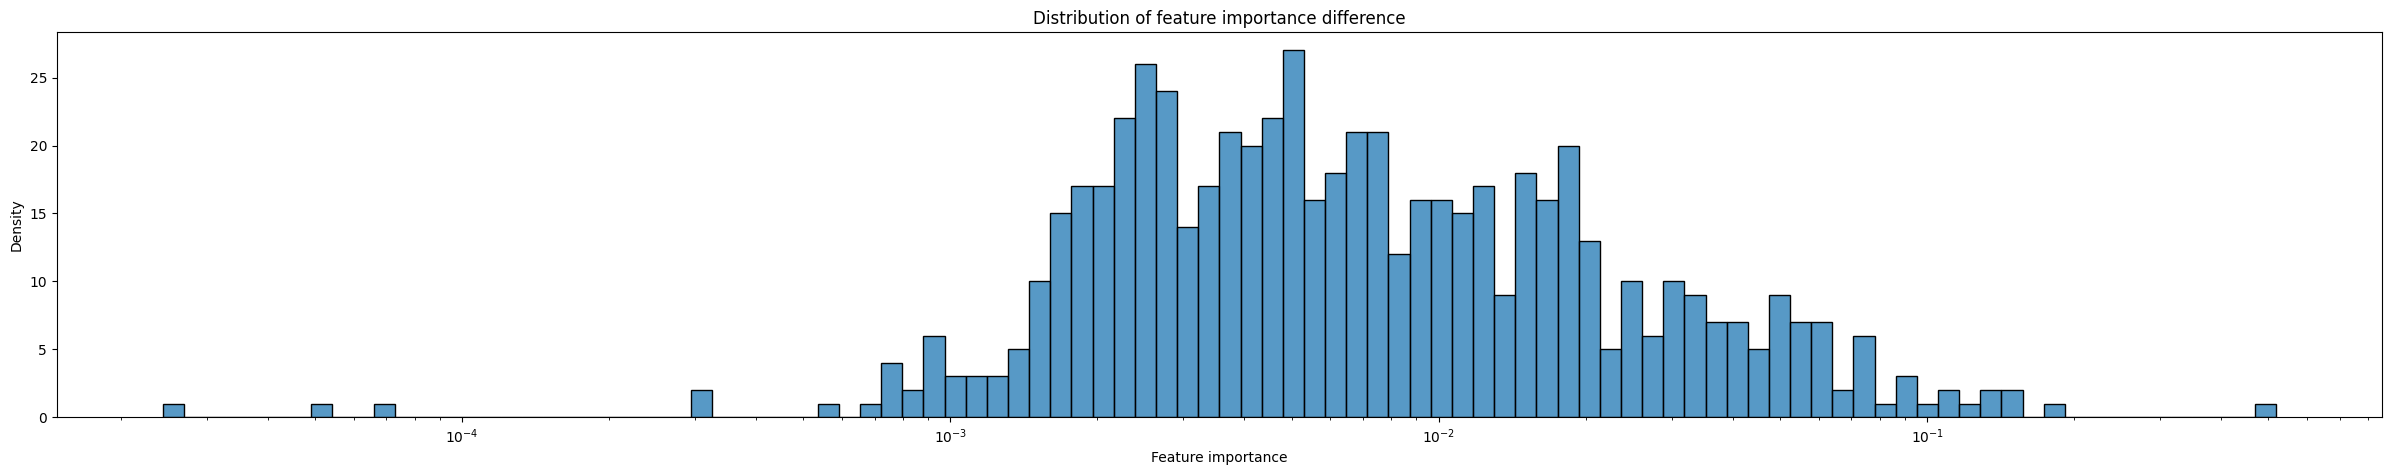

In [69]:
plt.close()
plt.figure(figsize=(30,5))
sns.histplot(data=diff, bins=100, log_scale=True)
plt.title('Distribution of feature importance difference')
plt.xlabel('Feature importance')
plt.ylabel('Density')
plt.show()

In [67]:
epsilon = 0.02  # Modifica questo valore
significant_features = diff[diff >= epsilon].index.tolist()

print(f"Feature con differenza >= {epsilon}:")
significant_featuresEnriched = addClusterGenes(significant_features)
print(len(significant_featuresEnriched), significant_featuresEnriched)

Feature con differenza >= 0.02:
DEFA4 False
COX7A2 True
RPS4Y1 False
IFI44 False
114 ['FA2H', 'CDC27', 'ADAT1', 'FEZ1', 'SIRPA', 'FGGY', 'MRFAP1L1', 'ACO2', 'CSK', 'HRH4', 'ARID3B', 'SF3B2', 'CXCR4', 'NOL11', 'ZNF473', 'ZNF711', 'TENM1', 'CHST2', 'KCTD2', 'AQR', 'CYP27A1', 'CBLL1', 'FZD1', 'EIF4G1', 'RPAIN', 'COQ7', 'PLA2G7', 'NDUFS5', 'SNAP29', 'AVPR1A', 'SERTAD2', 'TM9SF1', 'TOR1B', 'KLF4', 'PF4V1', 'UBE3A', 'SLC6A15', 'GORASP1', 'MAMLD1', 'ADAM15', 'BZW1', 'HFE', 'H2AZ1', 'SLC2A1', 'IFNA4', 'RPL11', 'ABCA1', 'PRR13', 'TMEM183A', 'IL27RA', 'SCMH1', 'ZNF354A', 'EXOSC1', 'SRSF9', 'CD74', 'SPOP', 'CCNE2', 'PLLP', 'HMGN1', 'TMSB10', 'H2BC21', 'MFN2', 'UBE2B', 'NUAK2', 'KLF3-AS1', 'IPPK', 'SFSWAP', 'MYOM1', 'GNAQ', 'ING2', 'NEDD8', 'HLA-DRB1', 'RBM6', 'SYF2', 'RSRC2', 'STARD3', 'RAPGEF1', 'DEPP1', 'CDKN1C', 'TAGLN', 'LGALS1', 'MOGS', 'TRIB1', 'CAPN1', 'DEDD', 'GSTK1', 'ZFYVE9', 'H2AC17', 'CROCC', 'DNAJA3', 'CCNJL', 'IER5', 'CPA3', 'ADRB2', 'EGR3', 'MAB21L1', 'RMC1', 'PCTP', 'MATK', 'RFTN1

<h3>Dependence plot with interactions for the 2 known gene of the family HLA</h3>

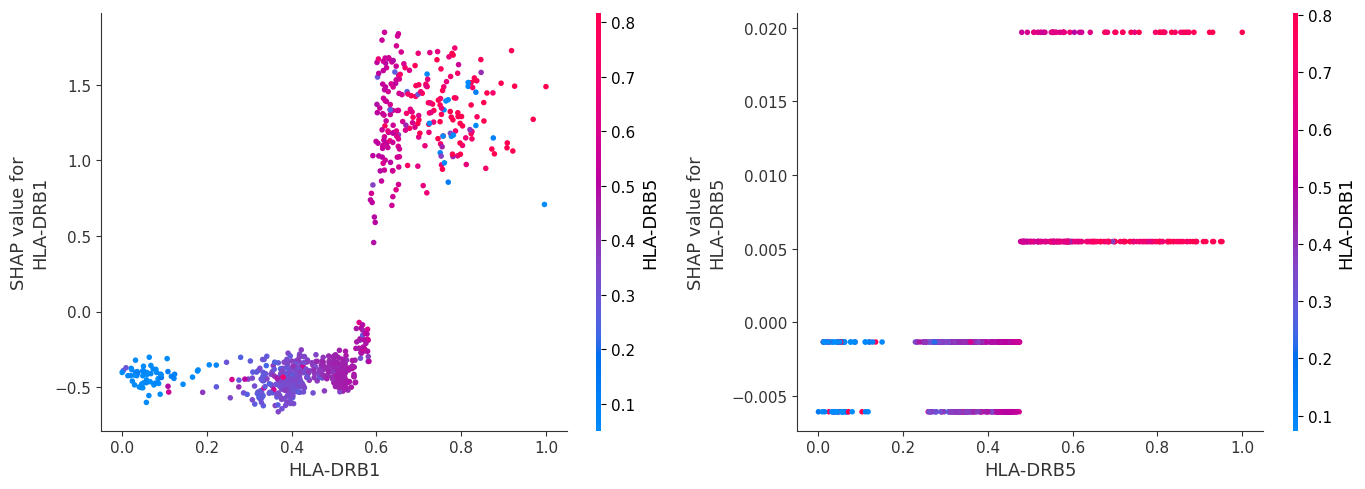

In [ ]:
shap_values = shap_object.values

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
shap.dependence_plot("HLA-DRB1", shap_values, current_Scaled, show=False, interaction_index='HLA-DRB5', ax=ax[0])
shap.dependence_plot("HLA-DRB5", shap_values, current_Scaled, show=False, interaction_index='HLA-DRB1', ax=ax[1])
plt.tight_layout()

<h3>Dependence plot of the first 20 features for importance</h3>

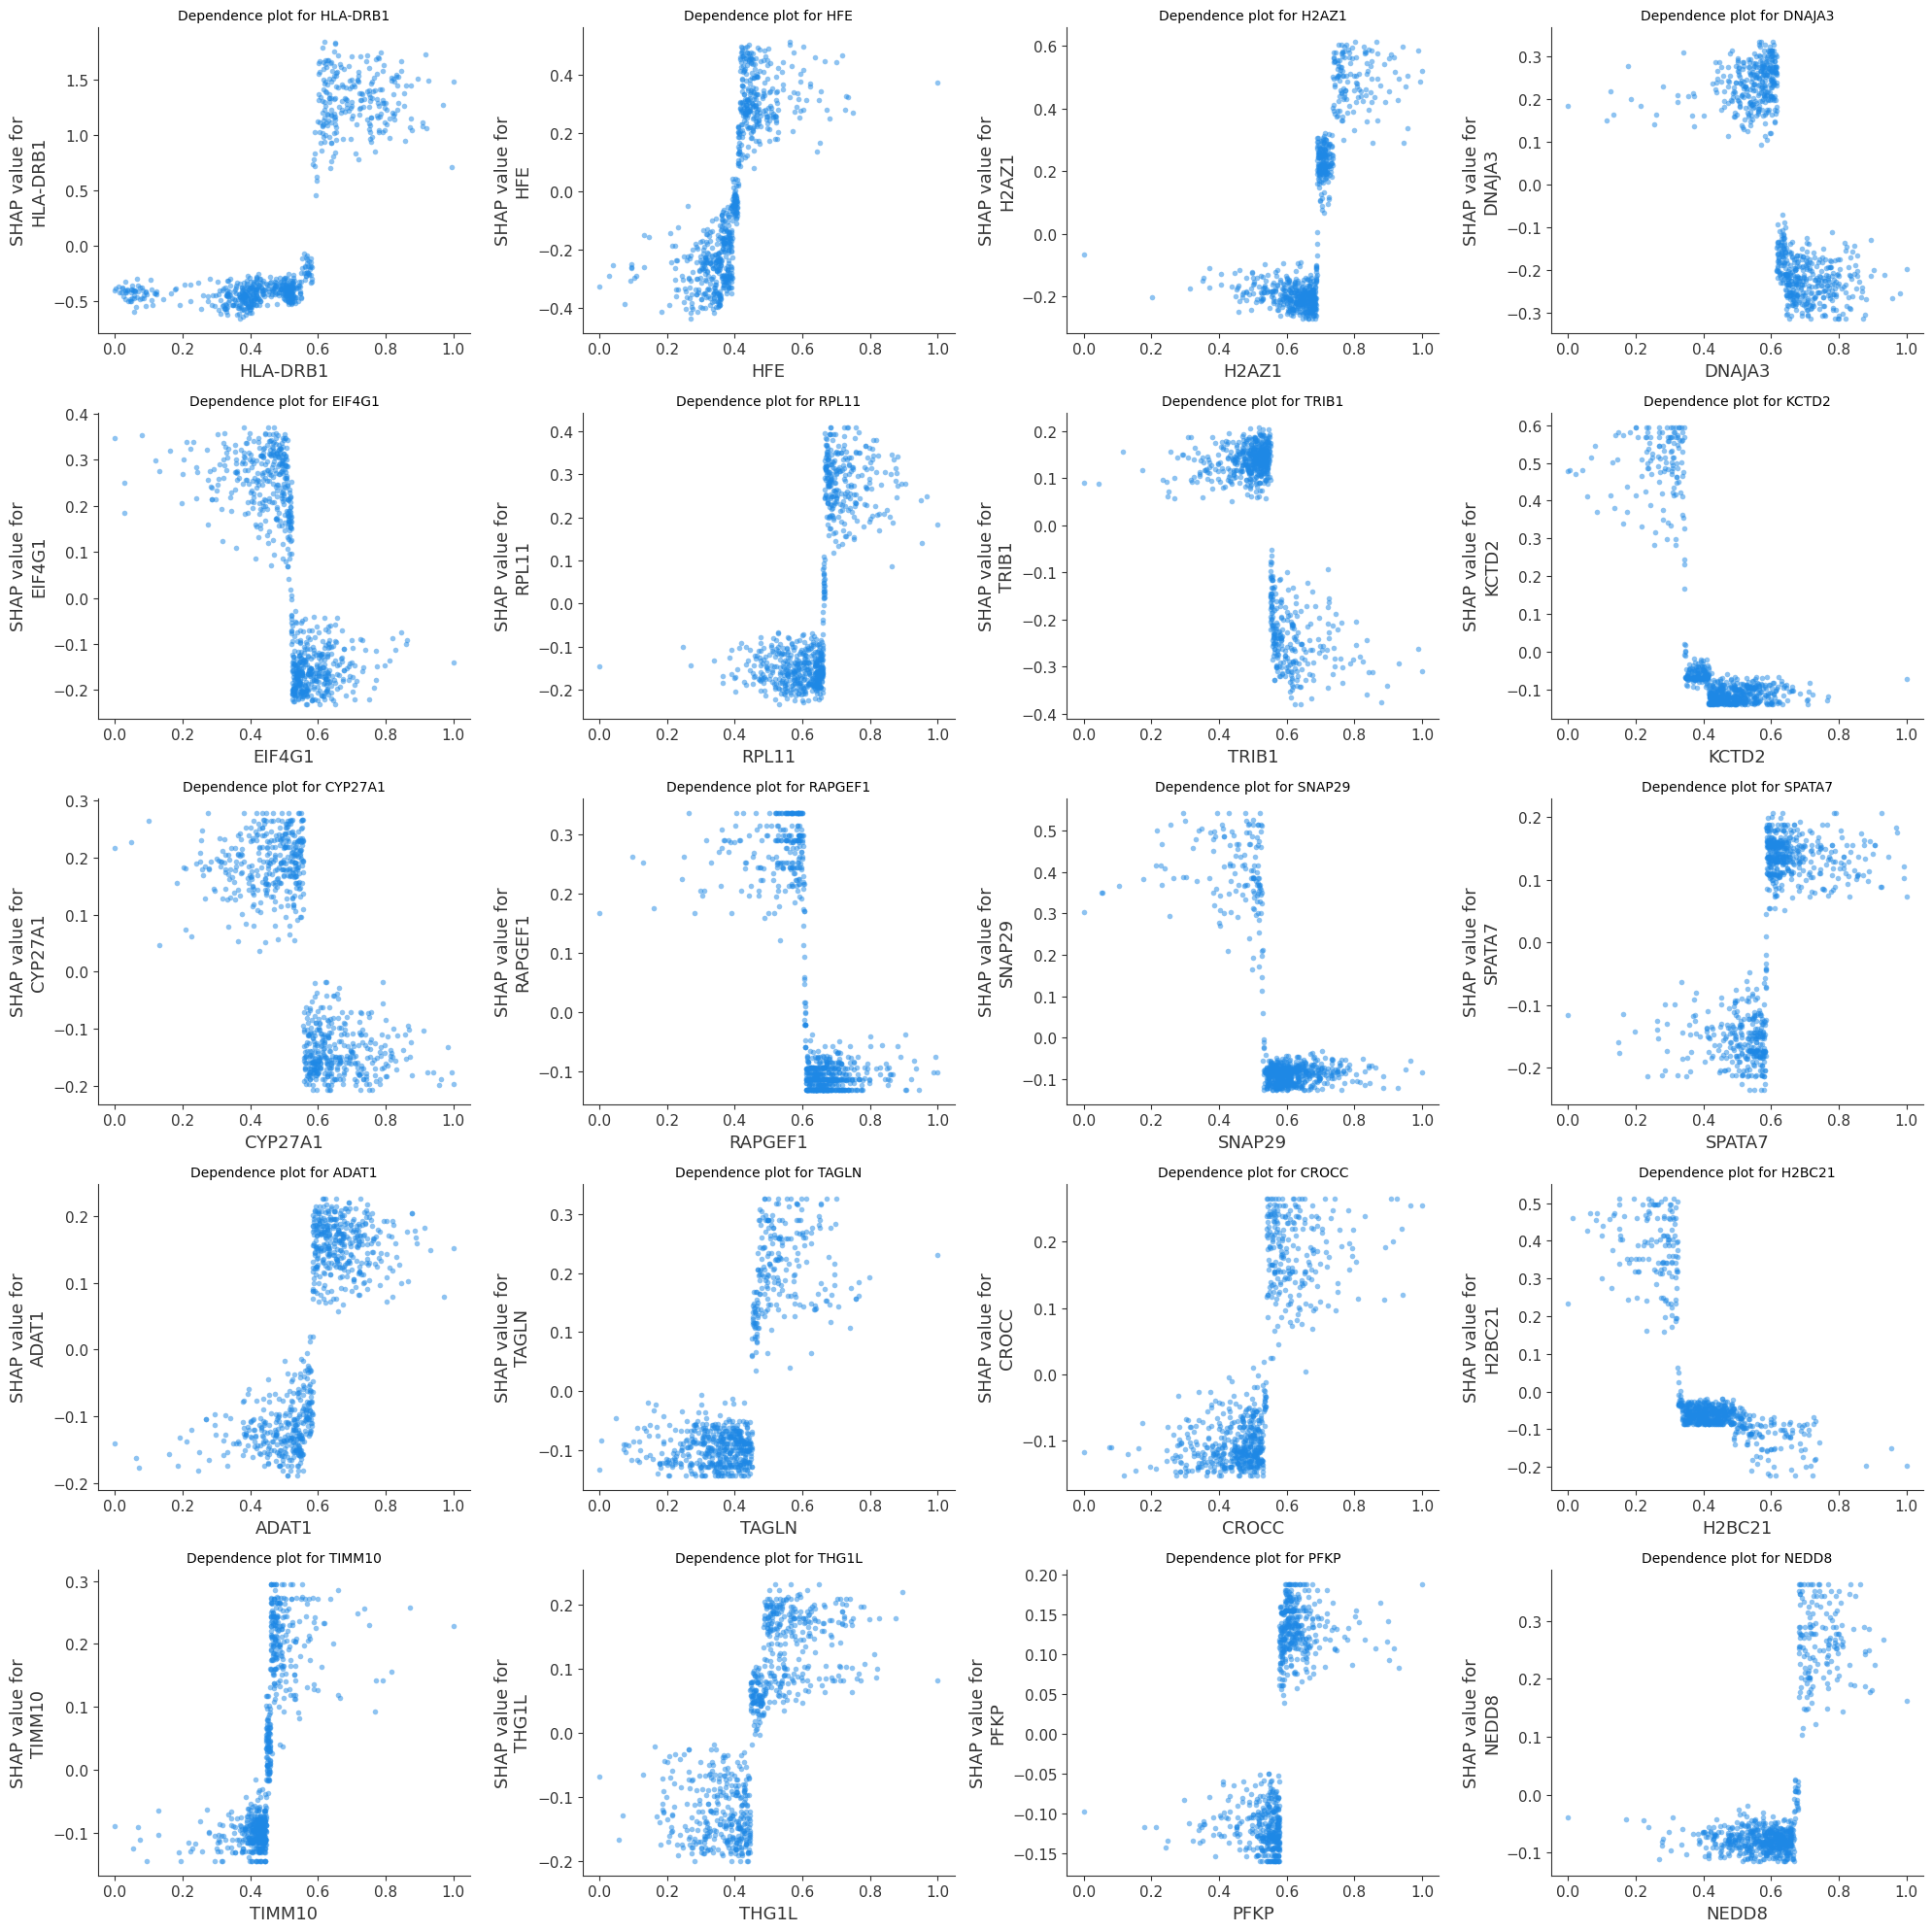

In [14]:
plt.close()

n = 5
fig, axes = plt.subplots(n, 4, figsize=(20, 20))  # Dimensioni figura
axes = axes.flatten()  # Appiattisci l'array di assi per iterare

features = list(expl_sorted.keys())[:20]  # Prendi le prime 4 features

# Loop sulle features
for i, feature in enumerate(features):
    if i >= len(axes):  # Evita errori se troppe features
        break
    shap.dependence_plot(
        feature,
        shap_values,  # Usa .values se shap_values è un Explanation object
        current_Scaled,      # Il tuo DataFrame (o array)
        interaction_index=None,
        ax=axes[i],          # Specifica l'asse corrente
        alpha=0.5,
        show=False
    )
    
    axes[i].set_title(f'Dependence plot for {feature}', fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Migliora lo spacing
plt.show()

<h3>Dependence plot with interactions beetween the combination of the first 5 features for importance</h3>

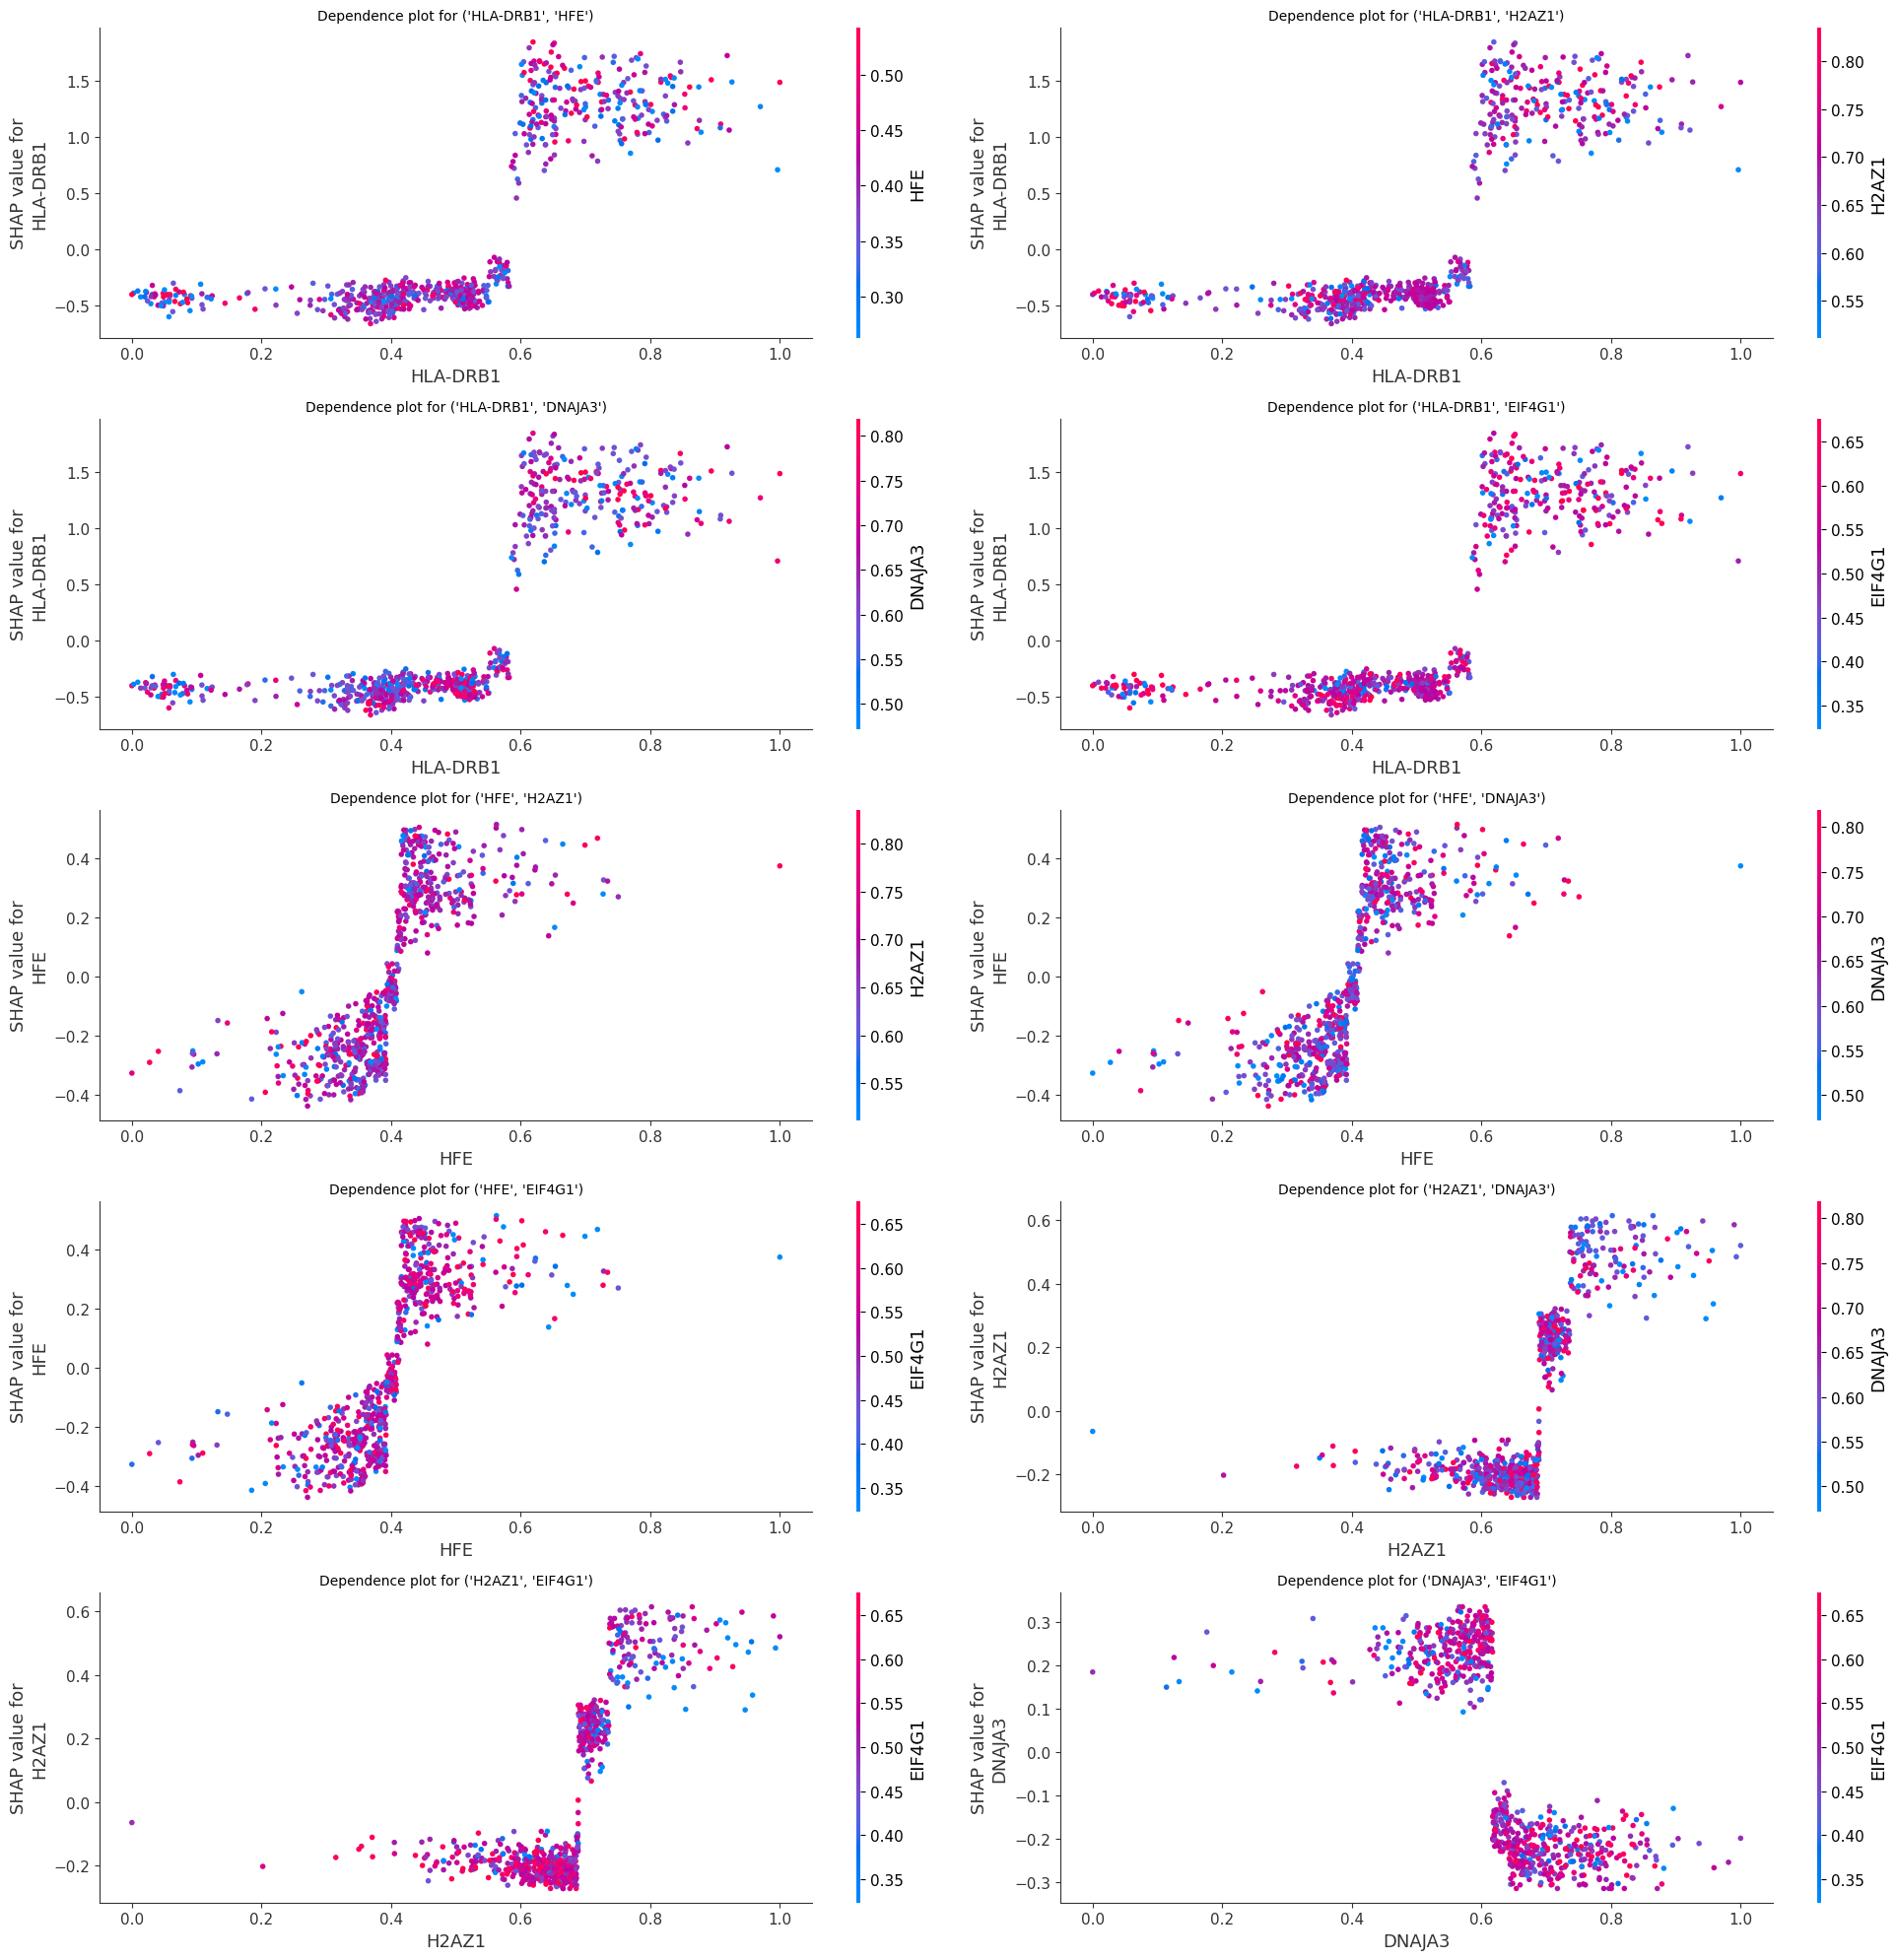

In [17]:
plt.close()

n = 5
fig, axes = plt.subplots(n, 2, figsize=(20, 20))  # Dimensioni figura
axes = axes.flatten()  # Appiattisci l'array di assi per iterare

features = list(expl_sorted.keys())[:5]  # Prendi le prime 4 features
featuresCoupled = list(combinations(features, 2))

# Loop sulle features
for i, feature in enumerate(featuresCoupled):
    if i >= len(axes):  # Evita errori se troppe features
        break
    shap.dependence_plot(
        feature[0],
        shap_values,  # Usa .values se shap_values è un Explanation object
        current_Scaled,      # Il tuo DataFrame (o array)
        interaction_index=feature[1],
        ax=axes[i],          # Specifica l'asse corrente
        alpha=1,
        show=False
    )
    
    axes[i].set_title(f'Dependence plot for {feature}', fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Migliora lo spacing
plt.show()

<h3>Distribution of feature importances</h3>

Mean: 0.029104202604843938
Stadnard Deviation: 0.044206212780879654
Number of features of 0 sigma: 171 ['HLA-DRB1', 'HFE', 'H2AZ1', 'DNAJA3', 'EIF4G1', 'RPL11', 'TRIB1', 'KCTD2', 'CYP27A1', 'RAPGEF1', 'SNAP29', 'SPATA7', 'ADAT1', 'TAGLN', 'CROCC', 'H2BC21', 'TIMM10', 'THG1L', 'PFKP', 'NEDD8', 'ZNF473', 'SYF2', 'CDKN1C', 'CSK', 'ADAM15', 'RBM6', 'EIF2AK2', 'SFSWAP', 'EXOSC1', 'ABL1', 'MYOM1', 'ABCA1', 'KLF3-AS1', 'SERTAD2', 'MOGS', 'TMSB10', 'ADRB2', 'STARD3', 'MAB21L1', 'CXCR4', 'RFTN1', 'IFNA4', 'RPAIN', 'GORASP1', 'CBLL1', 'TPST1', 'PCTP', 'DEPP1', 'ZNF711', 'MAMLD1', 'BZW1', 'IL27RA', 'CHST2', 'TM9SF1', 'CABP5', 'ING2', 'IER5', 'UBE2B', 'ZNF354A', 'IPPK', 'AQR', 'COX7A2', 'PF4V1', 'H2AC17', 'NOL11', 'CDC27', 'MRFAP1L1', 'KLF4', 'SLC2A1', 'PLA2G7', 'CENPB', 'BID', 'SCMH1', 'PLLP', 'NUAK2', 'CCNE2', 'FZD1', 'HMGN1', 'GNAQ', 'KIR2DS5', 'RSRC2', 'ZFYVE9', 'DEDD', 'CAPN1', 'IFNA6', 'PEX6', 'PHF1', 'FEZ1', 'AVPR1A', 'EGR3', 'CPA3', 'ACO2', 'PRKCD', 'LGALS1', 'RMC1', 'TENM1', 'SRSF9', 'C4o

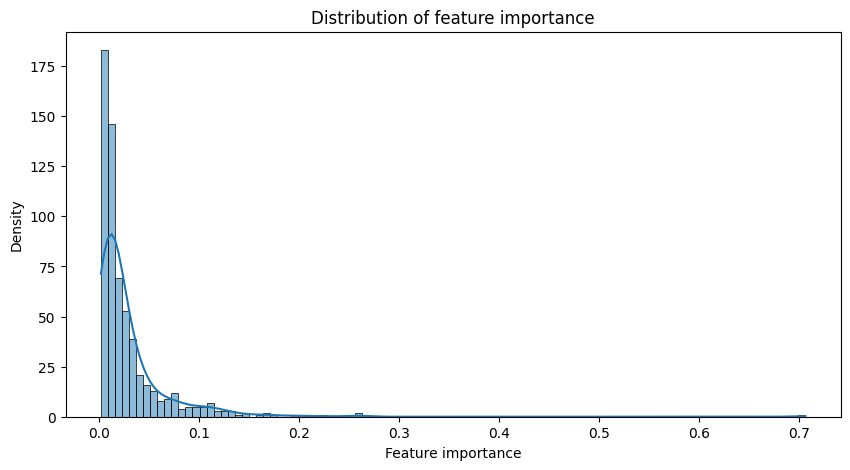

In [60]:
non_zeroShap = [value for value in expl_sorted.values() if value != 0]
mean = np.mean(non_zeroShap)
std = np.std(non_zeroShap)

print('Mean:', mean)
print('Stadnard Deviation:', std)
k=0
bestFeatures = [key for key, value in expl_sorted.items() if value > (k*std)+mean]
print(f"Number of features of {k} sigma:", len(bestFeatures), bestFeatures)

plt.close()
plt.figure(figsize=(10,5))
sns.histplot(data=non_zeroShap, bins=100, kde=True)
plt.title('Distribution of feature importance')
plt.xlabel('Feature importance')
plt.ylabel('Density')
plt.show()

<h3>Cumulative Importance</h3>

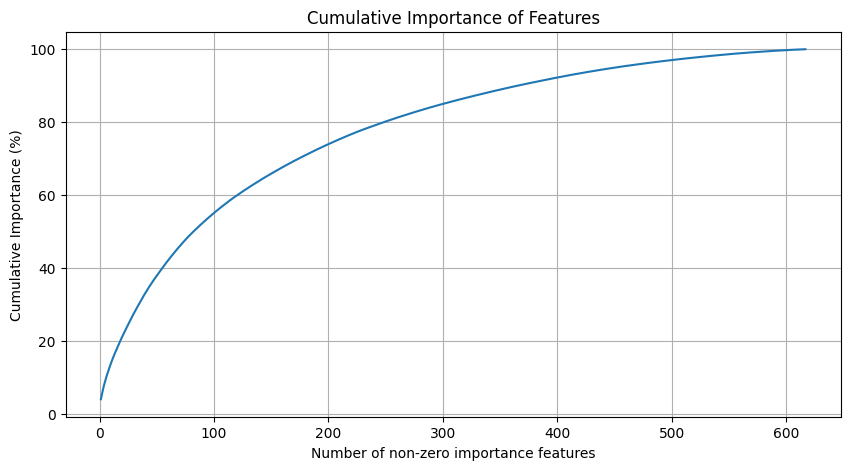

In [61]:
non_zeroShap = [value for value in expl_sorted.values() if value != 0]
cumulativeImportance = (np.array(non_zeroShap).cumsum() / np.array(non_zeroShap).sum()) * 100

plt.close()
plt.figure(figsize=(10,5))
plt.plot(range(1, len(cumulativeImportance)+1), cumulativeImportance)
plt.xlabel('Number of non-zero importance features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Importance of Features')
plt.grid()
plt.show()

In [63]:
enrichedGenes = addClusterGenes(list(expl_sorted.keys())[:250])
print(len(enrichedGenes), enrichedGenes)

DEFA4 False
COX7A2 True
RPS4Y1 False
IFI44 False
252 ['HLA-DRB1', 'HFE', 'H2AZ1', 'DNAJA3', 'EIF4G1', 'RPL11', 'TRIB1', 'KCTD2', 'CYP27A1', 'RAPGEF1', 'SNAP29', 'SPATA7', 'ADAT1', 'TAGLN', 'CROCC', 'H2BC21', 'TIMM10', 'THG1L', 'PFKP', 'NEDD8', 'ZNF473', 'SYF2', 'CDKN1C', 'CSK', 'ADAM15', 'RBM6', 'EIF2AK2', 'SFSWAP', 'EXOSC1', 'ABL1', 'MYOM1', 'ABCA1', 'KLF3-AS1', 'SERTAD2', 'MOGS', 'TMSB10', 'ADRB2', 'STARD3', 'MAB21L1', 'CXCR4', 'RFTN1', 'IFNA4', 'RPAIN', 'GORASP1', 'CBLL1', 'TPST1', 'PCTP', 'DEPP1', 'ZNF711', 'MAMLD1', 'BZW1', 'IL27RA', 'CHST2', 'TM9SF1', 'CABP5', 'ING2', 'IER5', 'UBE2B', 'ZNF354A', 'IPPK', 'AQR', 'COX7A2', 'HINT1', 'UQCRQ', 'PF4V1', 'H2AC17', 'NOL11', 'CDC27', 'MRFAP1L1', 'KLF4', 'SLC2A1', 'PLA2G7', 'CENPB', 'BID', 'SCMH1', 'PLLP', 'NUAK2', 'CCNE2', 'FZD1', 'HMGN1', 'GNAQ', 'KIR2DS5', 'RSRC2', 'ZFYVE9', 'DEDD', 'CAPN1', 'IFNA6', 'PEX6', 'PHF1', 'FEZ1', 'AVPR1A', 'EGR3', 'CPA3', 'ACO2', 'PRKCD', 'LGALS1', 'RMC1', 'TENM1', 'SRSF9', 'C4orf19', 'SPOP', 'SLC6A15', 'CD74'

<h3>SHAP vs DEA graph</h3>

In [24]:
current = dataset.copy()
current.insert(0, 'Label', label)

warnings.filterwarnings("ignore")

currentControl = current.loc[current['Label'] == 0, :]
currentMS = current.loc[current['Label'] == 1, :]

currentControl.drop(columns=['Label'], inplace=True)
currentMS.drop(columns=['Label'], inplace=True)

p_values = [mannwhitneyu(currentControl[gene], currentMS[gene])[1] for gene in currentControl.columns]
boolean, p_values_corrected = fdrcorrection(p_values, alpha=0.05)
deGenes = {gene:value for gene, sig, value in zip(currentControl.columns, boolean, p_values_corrected) if sig}

print(deGenes)

{'MAPK1IP1L': 0.03341525820715502, 'CMKLR1': 0.012156940390486155, 'C14orf93': 0.0003668647351217506, 'ANAPC15': 0.016818042881482368, 'PCBD1': 0.04192390503239832, 'RASSF7': 0.015887538422114423, 'UBXN7': 0.02500324284079649, 'GYPA': 0.023172342324887813, 'PTPN22': 0.04063294809803007, 'TNS1': 0.0002001291175814798, 'SLC22A17': 0.012156940390486155, 'ZNF324B': 0.04981932292444448, 'ZNF721': 0.00627152951126807, 'TRIOBP': 0.004163857679200432, 'GSK3B': 0.046149218157510594, 'CTDSPL': 0.01952542385953892, 'CELSR1': 0.0006976588019975237, 'ELOA': 1.0733601281365966e-05, 'HUWE1': 0.0004850555458521014, 'TNKS': 0.018489188046135915, 'CNBP': 0.014135372927631831, 'RNF122': 0.002669870021437154, 'TRIM3': 0.009622330141926282, 'PIK3R5': 0.018461184560599198, 'PRG4': 0.00021563279037456273, 'IFIT5': 0.02500324284079649, 'DUX4': 0.006352027156582134, 'RLF': 0.017149242213406243, 'CYBRD1': 0.012260990547010001, 'PSME4': 7.275677427471814e-06, 'SOD1': 7.079541600551131e-07, 'RXYLT1': 0.0017623592

In [33]:
dea_genes = joblib.load("deaGenesReduced.pkl")
sorted_dea_genes = dict(sorted(dea_genes.items(), key=lambda item: item[1]))
print(len(dea_genes.keys()), list(dea_genes.keys()))

1491 ['MAPK1IP1L', 'CMKLR1', 'C14orf93', 'ANAPC15', 'PCBD1', 'RASSF7', 'UBXN7', 'GYPA', 'PTPN22', 'TNS1', 'SLC22A17', 'ZNF324B', 'ZNF721', 'TRIOBP', 'GSK3B', 'CTDSPL', 'CELSR1', 'ELOA', 'HUWE1', 'TNKS', 'CNBP', 'RNF122', 'TRIM3', 'PIK3R5', 'PRG4', 'IFIT5', 'DUX4', 'RLF', 'CYBRD1', 'PSME4', 'SOD1', 'RXYLT1', 'TNS3', 'RIPOR1', 'COQ3', 'USP7', 'SKIL', 'SETBP1', 'CDC25C', 'DIAPH1', 'RAE1', 'EPB41L4A', 'GPATCH8', 'PREB', 'KRAS', 'PRRC2A', 'CABYR', 'INTS9', 'LCP1', 'POLR2K', 'ZNF574', 'ADGRG1', 'TUBB4B', 'DIP2C', 'SLC25A37', 'STIP1', 'PPCS', 'SAFB2', 'PWWP3A', 'SEMA4D', 'CCNH', 'FEZ1', 'NPFF', 'PRPF40A', 'SPARC', 'REL', 'CEBPA', 'ENTR1', 'ATF7IP', 'ETV3', 'ELAC1', 'RBMS2', 'TTLL4', 'LYN', 'PGM1', 'DBI', 'MS4A1', 'HMOX1', 'B3GALNT1', 'LUZP1', 'DPEP2', 'ZNF500', 'BTF3', 'HP1BP3', 'PRDM8', 'PKD2L2', 'HDLBP', 'ARFGEF2', 'SLC17A5', 'CBX3', 'CDH2', 'MANF', 'SIRPA', 'PRUNE1', 'ATG13', 'NDUFA8', 'YEATS4', 'RPS20', 'MBP', 'CCNA1', 'KCTD13', 'PLXDC2', 'CXCL2', 'TOR1A', 'MCUB', 'RBX1', 'ENO3', 'CCAR2',

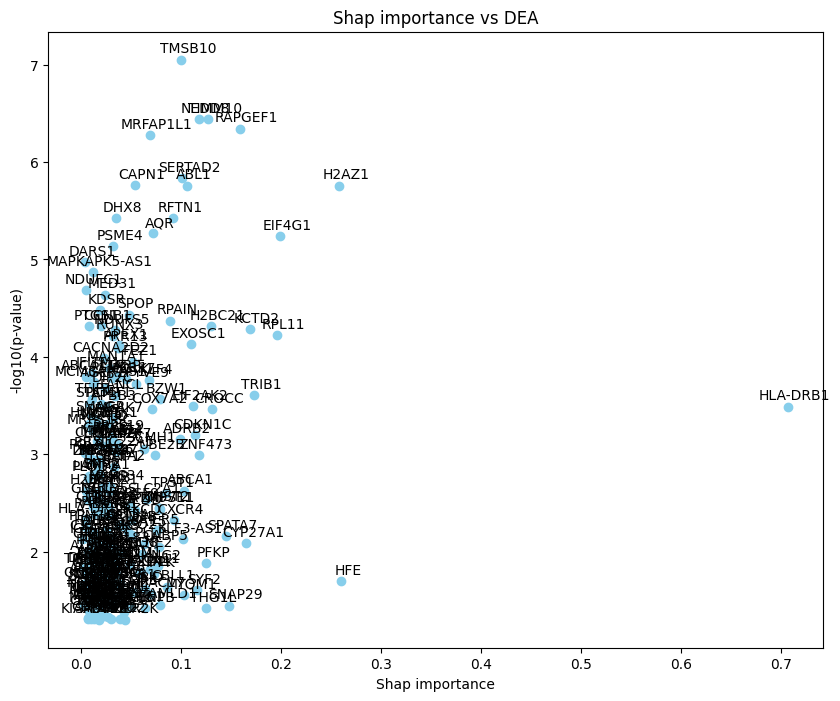

In [28]:
point_x = []
point_y = []

for gene, value in expl_sorted.items():
    if value > 0 and gene in dea_genes.keys():
        point_x.append(expl_sorted[gene])
        point_y.append(-np.log10(dea_genes[gene]))

plt.figure(figsize=(10, 8))
plt.scatter(point_x, point_y, color='skyblue')

nonZero = [k for k, v in expl_sorted.items() if v > 0]

i = 0
for gene, value in expl_sorted.items():
    if value > 0 and gene in dea_genes.keys():
        plt.annotate(gene, (point_x[i], point_y[i]), textcoords="offset points", xytext=(5,5), ha='center')
        i += 1

plt.xlabel('Shap importance')
plt.ylabel('-log10(p-value)')
plt.title('Shap importance vs DEA')
plt.show()

<h3>Venn diagram SHAP and DEA</h3>

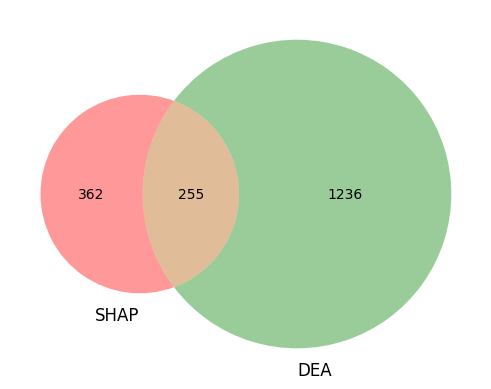

In [29]:
venn2(subsets = [set(feature_nonZero), set(dea_genes.keys())], set_labels = ('SHAP', 'DEA'))
plt.show()

Feature important for SHAP not detected by DEA

In [30]:
print(len(set.difference(set(feature_nonZero), set(dea_genes.keys()))), set.difference(set(feature_nonZero), set(dea_genes.keys())))

362 {'SLC2A9', 'BSCL2', 'COPS5', 'CES3', 'KCNE2', 'GPRC5A', 'MPST', 'DDX5', 'KIF14', 'PLAAT3', 'MTAP', 'CDC42', 'ZSCAN5A', 'CHPF', 'ALOX15', 'POLM', 'H2AC15', 'OR1E1', 'MCTP1', 'SFXN1', 'IFNW1', 'SIX1', 'CLEC3B', 'SLC35E2A', 'NCSTN', 'PRKX', 'PRC1', 'A4GALT', 'TRMT112', 'NEDD9', 'CLCN4', 'ZC3HAV1', 'CFI', 'RUNX1', 'EXT2', 'CD74', 'PDE1B', 'CRYBA4', 'SLC25A24', 'ADPRH', 'FAM124B', 'ATAD5', 'SPDEF', 'FEZ2', 'NUAK2', 'TMCO1', 'ADAT1', 'UBE2C', 'IFNA6', 'RBL1', 'TP53', 'GORASP1', 'LLPH', 'FKBP5', 'CA8', 'TAGLN', 'NRXN1', 'SKP2', 'B4GALT4', 'RTN3', 'NCAPH', 'CCDC7', 'SP100', 'PLA2G7', 'GNG4', 'PTPN6', 'ASRGL1', 'C4orf19', 'PRRG3', 'ENO1', 'CYTH2', 'APOL2', 'NMRK1', 'DDX60', 'TBCC', 'NTRK1', 'PPIF', 'DDX39A', 'ZC3H7A', 'GSTT1', 'CHM', 'PSME3IP1', 'FICD', 'KCTD5', 'ZCCHC2', 'PGR', 'PEX6', 'CRYGA', 'IL27RA', 'TXK', 'DSP', 'CLDN3', 'ANXA2P1', 'MYC', 'HDC', 'HEY2', 'OSM', 'FGGY', 'ARPC5L', 'DAB1', 'ZNF639', 'STAG3', 'RCC1L', 'MAP3K9', 'DENND4C', 'NR0B2', 'CSTA', 'NR6A1', 'ADPRM', 'OR1G1', 'DNAH6

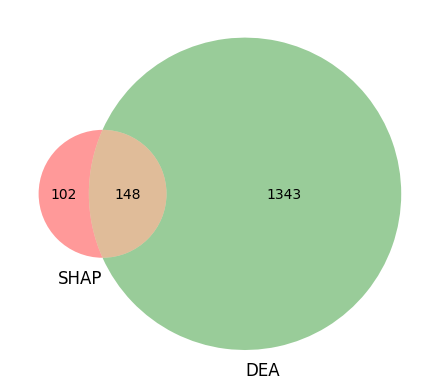

In [32]:
venn2(subsets = [set(feature_nonZero[:250]), set(dea_genes.keys())], set_labels = ('SHAP', 'DEA'))
plt.show()

Known feature important for MS

In [65]:
limit = None

for gene in ["GABPA", "CTCF", "EGR1", "YY1", "SPI1", "CLOCK", "ARNTL", "BACH1", "GFI1", "IFNB1", "MOG",  "MBP", "CD42", "IFNG", "IL17A", "IL10", "TNF", "IL1B", "IL6", "TNFRSF1A", "CYP27B1", "IL7R", "HLA-DRB1", "HLA-DRB5", "IL2RA"]:
    if gene in dataset.columns:
        if gene in feature_nonZero[:limit] and gene in list(sorted_dea_genes.keys())[:limit]:
            print(gene, "Both")
        elif gene in feature_nonZero[:limit]:
            print(gene, "SHAP")
        elif gene in list(sorted_dea_genes.keys())[:limit]:
            print(gene, "DEA")
        else:
            print(gene, "None")
    else:
        print(gene, "Not in dataset")

GABPA None
CTCF DEA
EGR1 None
YY1 None
SPI1 None
CLOCK DEA
ARNTL Not in dataset
BACH1 None
GFI1 DEA
IFNB1 None
MOG None
MBP DEA
CD42 Not in dataset
IFNG None
IL17A None
IL10 None
TNF None
IL1B None
IL6 None
TNFRSF1A None
CYP27B1 None
IL7R None
HLA-DRB1 Both
HLA-DRB5 Both
IL2RA SHAP


<h2>xxAI Analysis</h2>

In [35]:
color = ['red', 'navy', 'grey', 'yellow', 'green', 'purple', 'pink', 'brown']
classiDataset = ['GSE41848', 'GSE41849', 'GSE146383', 'GSE13732', 'GSE136411', 'GSE17048', 'GSE41890', 'GSE21942']
classiLabel = ['Control', 'MS']
colorLabel = ['Black', 'Orange']
classiGender = ['Female', 'Male']
colorGender = ['Red', 'Blue']

dataset = pd.read_csv('../../Dataset/MergedDatasetReducedCombatDeclustered_symbol.csv')
dataset['Gender'] = joblib.load("genderReduced.pkl")
dataset

SampleID      PatientID  Label       XPO6  \
0               0-GSM1026056_600009.0001  0-600009.0001      1  10.525171   
1    0-GSM1026057_600009.0001-FollowUp_1  0-600009.0001      1  10.881165   
2                0-GSM1026058_41461.0001   0-41461.0001      1  11.430331   
3                0-GSM1026059_41462.0001   0-41462.0001      1  11.385201   
4               0-GSM1026060_600029.0001  0-600029.0001      1  11.344344   
..                                   ...            ...    ...        ...   
724                      6-GSM545842_M10          6-M10      1  10.931859   
725                      6-GSM545843_M11          6-M11      1  10.765313   
726           6-GSM545844_M11-FollowUp_1          6-M11      1  10.977433   
727                      6-GSM545845_M12          6-M12      1  10.589295   
728           6-GSM545846_M12-FollowUp_1          6-M12      1  11.134102   

       ARPC1A     THOP1    ATP2B2      CSTA       PKM  MAPK1IP1L  ...  \
0    7.022214  6.483224  5.848133  7.591375  8.987009   9.548412  ...   
1    6.973561  6.813249  5.887911  7.668762  9.267965   9.533519  ...   
2    7.140780  6.688973  5.984697  7.571597  9.025906   9.516713  ...   
3    7.144255  6.482745  5.616827  7.819636  9.037302   9.581727  ...   
4    7.067116  6.384345  5.762024  7.962971  9.252510   9.611660  ...   
..        ...       ...       ...       ...       ...        ...  ...   
724  7.106400  6.789337  6.003297  7.964093  9.272532   9.508226  ...   
725  7.079116  6.572470  5.744757  7.963980  9.123222   9.528200  ...   
726  7.030231  6.554086  5.716029  7.972142  9.102181   9.592449  ...   
727  7.081161  6.484474  5.744757  7.956867  9.140242   9.534618  ...   
728  7.035903  6.556645  5.601516  7.959362  9.151900   9.597398  ...   

       MS4A6A     BAZ2A      TPM1    DIABLO     DOC2A     DEFA4    COX7A2  \
0    9.119511  7.989939  7.300196  7.917960  5.448753  6.064862  8.905161   
1    9.133109  8.325695  7.226071  7.920274  5.776065  6.204405  9.027083   
2    9.222653  8.301554  7.299852  7.866331  5.740622  6.051944  8.936827   
3    9.323385  8.333977  7.363228  7.953213  5.165763  6.114210  9.250595   
4    9.388868  8.496262  7.254713  7.891466  5.287396  5.935075  9.036619   
..        ...       ...       ...       ...       ...       ...       ...   
724  9.286014  8.442553  7.370798  7.970275  5.338771  6.390358  9.111883   
725  9.269902  8.108137  7.307330  7.984256  5.452894  5.961750  9.158106   
726  9.253054  8.279138  7.338065  7.993246  5.532808  5.878172  9.134744   
727  9.256837  8.083611  7.385615  7.974383  5.427824  6.514266  9.168598   
728  9.266940  8.331888  7.382921  7.974383  5.456992  6.426990  9.118374   

       RPS4Y1     IFI44  Gender  
0    6.083871  7.861560  Female  
1    5.938436  7.793113  Female  
2    5.924100  8.199732  Female  
3    5.951088  7.803589  Female  
4    6.151681  8.945151  Female  
..        ...       ...     ...  
724  6.359453  7.864455  Female  
725  6.377977  7.876844  Female  
726  6.361933  7.872425  Female  
727  6.343867  7.930993  Female  
728  6.418308  7.887741  Female  

[729 rows x 11486 columns]

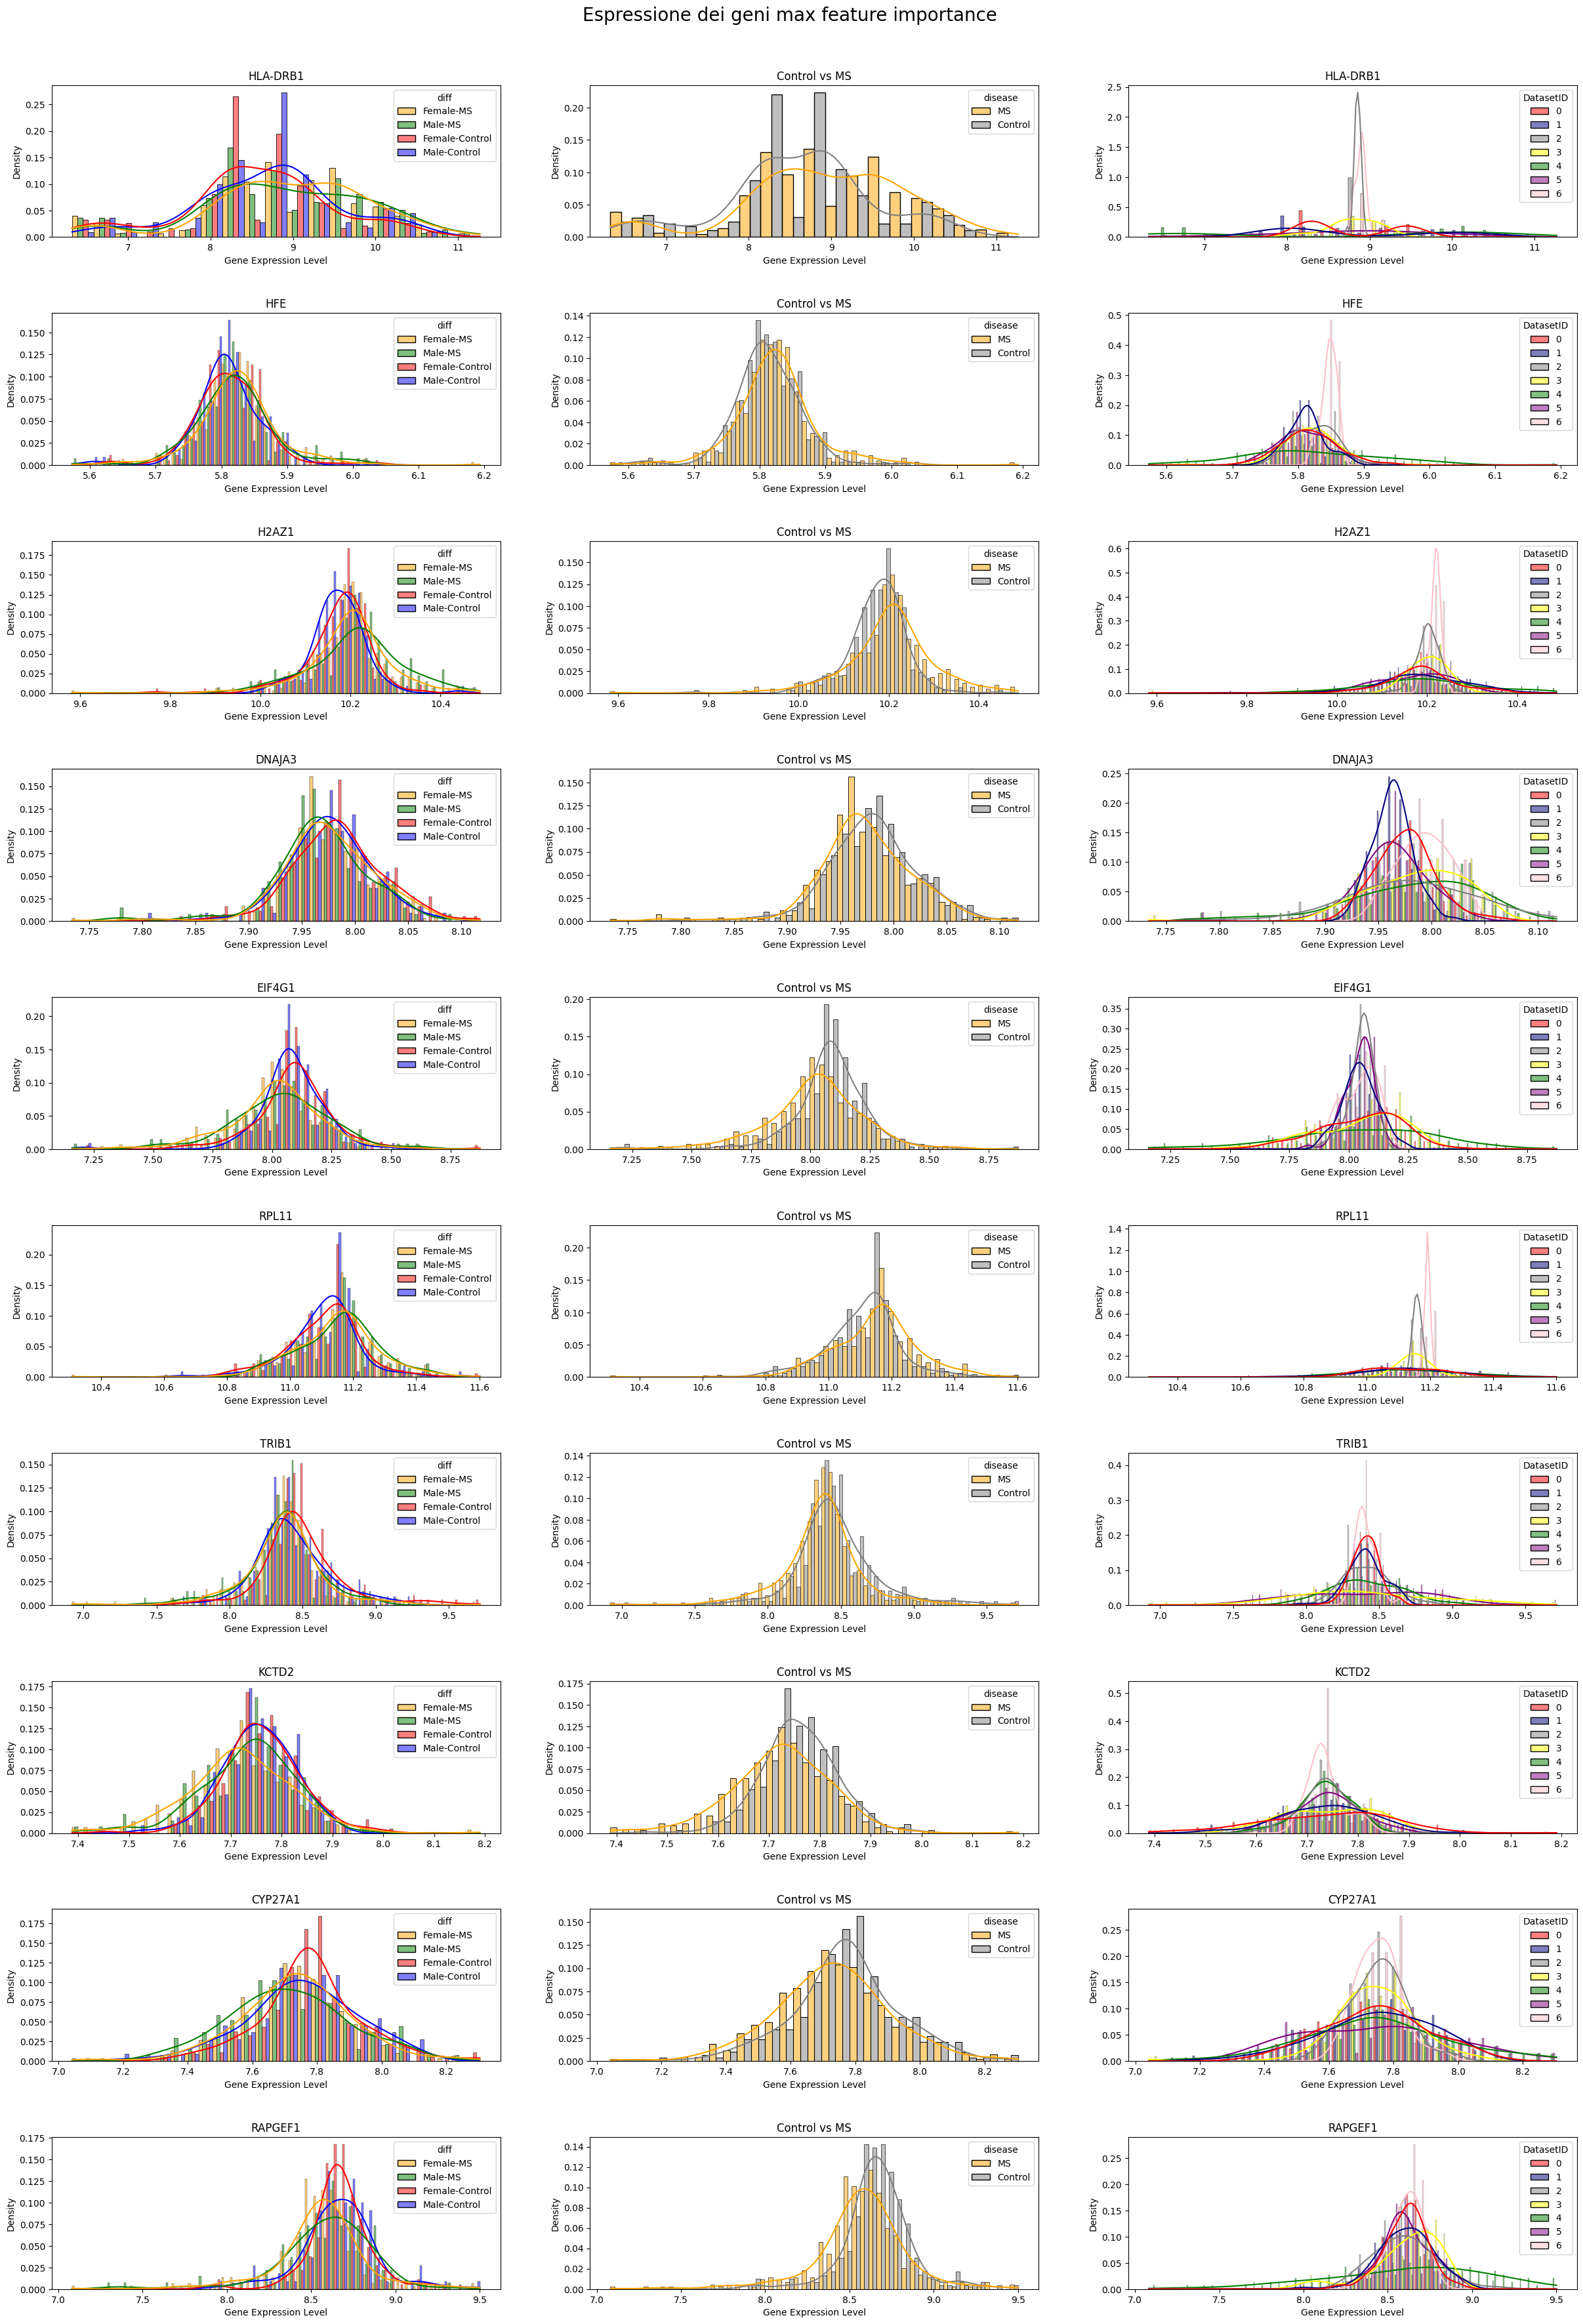

In [36]:
current = dataset.copy()

warnings.filterwarnings("ignore")

current['disease'] = current['Label'].apply(lambda x: 'MS' if x == 1 else 'Control')
current['diff'] = current['Gender']+"-"+current['disease'].astype(str)
current['DatasetID'] = current['SampleID'].apply(lambda x: x.split("-")[0])

gene_list = feature_nonZero[:10]

fig, axes = plt.subplots(len(gene_list), 3, figsize=(30, 40))

for i, gene in enumerate(gene_list):
    sns.histplot(data=current, x=gene, hue='diff', stat="probability",
                 kde=True, palette={'Female-MS':'orange', 'Female-Control':'red', 'Male-MS':'green', 'Male-Control':'blue'}, multiple='dodge', common_norm=False, ax=axes[i][0])
    axes[i][0].set_title(gene)
    axes[i][0].set_xlabel("Gene Expression Level")
    axes[i][0].set_ylabel("Density")


    sns.histplot(data=current, x=gene, hue='disease', stat="probability",
                 kde=True, palette={'Control': 'grey', 'MS': 'orange'}, multiple='dodge', common_norm=False, ax=axes[i][1])
    axes[i][1].set_title('Control vs MS')
    axes[i][1].set_xlabel("Gene Expression Level")
    axes[i][1].set_ylabel("Density")

    sns.histplot(data=current, x=gene, hue='DatasetID', stat="probability",
                 kde=True, palette={'0':'red', '1':'navy', '2':'grey', '3':'yellow', '4':'green', '5':'purple', '6':'pink', '7':'brown'}, multiple='dodge', common_norm=False, ax=axes[i][2])
    axes[i][2].set_title(gene)
    axes[i][2].set_xlabel("Gene Expression Level")
    axes[i][2].set_ylabel("Density")

    plt.subplots_adjust(hspace=0.5)

plt.suptitle("Espressione dei geni max feature importance", fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()

<h3>Insert ex clusters</h3>

In [ ]:
clusters = joblib.load("uniqueClustersReduced.pkl")
clusters

{('DEFA4', 'CEACAM6'): 'DEFA4',
 ('HINT1', 'COX7A2', 'UQCRQ'): 'COX7A2',
 ('PRKY', 'TXLNGY', 'RPS4Y1', 'EIF1AY'): 'RPS4Y1',
 ('OAS3', 'IFI44', 'RSAD2', 'IFI44L', 'HERC5'): 'IFI44'}

In [ ]:
for key, value in clusters.items():
    print(value, value in feature_nonZero)
    
    if value in feature_nonZero:
        insertElements = [gene for gene in key if gene != value]
        idx = feature_nonZero.index(value)
        feature_nonZero[idx+1:idx+1] = insertElements

DEFA4 True
COX7A2 True
RPS4Y1 False
IFI44 False


In [43]:
print(len(feature_nonZero), feature_nonZero[:250])

620 ['HLA-DRB1', 'HFE', 'H2AZ1', 'DNAJA3', 'EIF4G1', 'RPL11', 'TRIB1', 'KCTD2', 'CYP27A1', 'RAPGEF1', 'SNAP29', 'SPATA7', 'ADAT1', 'TAGLN', 'CROCC', 'H2BC21', 'TIMM10', 'THG1L', 'PFKP', 'NEDD8', 'ZNF473', 'SYF2', 'CDKN1C', 'CSK', 'ADAM15', 'RBM6', 'EIF2AK2', 'SFSWAP', 'EXOSC1', 'ABL1', 'MYOM1', 'ABCA1', 'KLF3-AS1', 'SERTAD2', 'MOGS', 'TMSB10', 'ADRB2', 'STARD3', 'MAB21L1', 'CXCR4', 'RFTN1', 'IFNA4', 'RPAIN', 'GORASP1', 'CBLL1', 'TPST1', 'PCTP', 'DEPP1', 'ZNF711', 'MAMLD1', 'BZW1', 'IL27RA', 'CHST2', 'TM9SF1', 'CABP5', 'ING2', 'IER5', 'UBE2B', 'ZNF354A', 'IPPK', 'AQR', 'COX7A2', 'HINT1', 'UQCRQ', 'PF4V1', 'H2AC17', 'NOL11', 'CDC27', 'MRFAP1L1', 'KLF4', 'SLC2A1', 'PLA2G7', 'CENPB', 'BID', 'SCMH1', 'PLLP', 'NUAK2', 'CCNE2', 'FZD1', 'HMGN1', 'GNAQ', 'KIR2DS5', 'RSRC2', 'ZFYVE9', 'DEDD', 'CAPN1', 'IFNA6', 'PEX6', 'PHF1', 'FEZ1', 'AVPR1A', 'EGR3', 'CPA3', 'ACO2', 'PRKCD', 'LGALS1', 'RMC1', 'TENM1', 'SRSF9', 'C4orf19', 'SPOP', 'SLC6A15', 'CD74', 'INTS5', 'ACRV1', 'FGGY', 'PARK7', 'MAP7D1', 'O

<h2>Ablation</h2>

In [11]:
dataset = pd.read_csv('MergedDatasetReducedCombatDeclustered_symbol.csv')

gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

Dataset di train:
(541, 11485)
I malati sono:  329
I sani sono:  212

Dataset di test:
(188, 11485)
I malati sono:  105
I sani sono:  83


In [12]:
model = joblib.load("xgbDefReduced.pkl")
originalScore = f1_score(y_test, model.predict(x_test))

def calcScores(x_test, y_test, model, originalScore):
    scores = {col: 0 for col in x_test.columns}
    i = 1
    for exclude in range(x_train.shape[1]):
        x = x_test.copy()
        x[x.columns[exclude]] = x[x.columns[exclude]].mean()
        scores[x.columns[exclude]] = originalScore / f1_score(y_test, model.predict(x))
        print(i)
        i += 1
    return scores

scores = calcScores(x_test, y_test, model, originalScore)
joblib.dump(scores, 'xgbDefReduced_ablationScores.pkl')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


['xgbDefReduced_ablationScores.pkl']

In [14]:
scores = joblib.load('xgbDefReduced_ablationScores.pkl')
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1], reverse=True))
bestFeatures = {key: value for key, value in sorted_scores.items() if value > 1.0}
worstFeatures = {key: value for key, value in sorted_scores.items() if value < 1.0}
print("Le feature migliori sono: ", len(bestFeatures), bestFeatures)
print("Le feature rumorose sono: ", len(worstFeatures), worstFeatures)

print(list(bestFeatures.keys()))

Le feature migliori sono:  0 {}
Le feature rumorose sono:  0 {}
[]
